# In Depth: Linear Regression

- Just as naive Bayes is a good starting point for classification tasks, linear regression models are a good starting point for regression tasks.
- They are popular because they can be fit very quickly, and are very interpretable.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Simple Linear Regression

- Start with the most familiar linear regression, a straight-line fit:
    $$
    y = ax + b
    $$
- $a$ is the *slope*; $b$ is the *intercept*.

- Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:

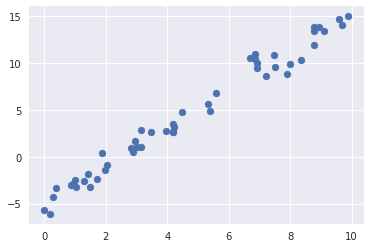

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

- Fit this data and construct the best-fit line using ``LinearRegression``.

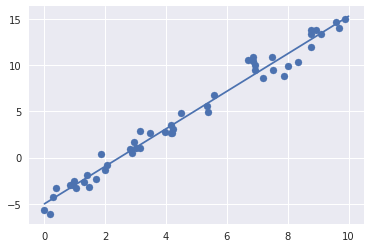

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

- The slope and intercept are contained in the model's fit parameters. Here the relevant parameters are ``coef_`` and ``intercept_``:

In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.02720881036
Model intercept: -4.99857708555


- The ``LinearRegression`` estimator can also handle multidimensional linear models of the form
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$

- Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.
- The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


- $y$ is constructed from three random $x$ values; the linear regression recovers the coefficients used to construct the data.
- We can use ``LinearRegression`` estimator to fit lines, planes, or hyperplanes to our data.
- It appears that this approach is limited to linear relationships between variables. It turns out we can relax this as well.

### Basis Function Regression

- You can adapt linear regression to nonlinear relationships between variables by transforming the data according to *basis functions*. The idea is to take our multidimensional linear model:

$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$

and build the $x_1, x_2, x_3,$ etc, from our single-dimensional input $x$. That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:

$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$

- Notice this is *still a linear model*—the coefficients $a_n$ never multiply or divide each other. Instead we have projected our one-dimensional $x$ values into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial basis functions
- Polynomial projection is built into Scikit-Learn using the ``PolynomialFeatures`` transformer:

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

- We converted a one-dimensional array into a three-dimensional array by taking the exponent of each value. The 3D dataset can be plugged into a linear regression.

- Let's use a pipeline to build a 7th-degree polynomial model.

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

- Now we can use the linear model to fit much more complicated relationships between $x$ and $y$. For example, here is a sine wave with noise.
- Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!

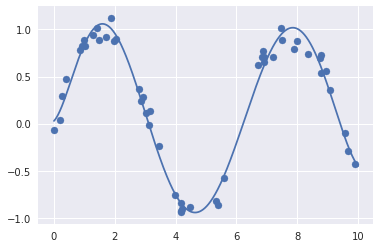

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

### Gaussian basis functions

- Another useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases. For example:

![](figures/05.06-gaussian-basis.png)

- The shaded regions are scaled basis functions, and when added together they reproduce the smooth curve through the data.
- These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them. (Scikit-Learn transformers are implemented as Python classes; reading Scikit-Learn's source is a good way to see how they can be created):

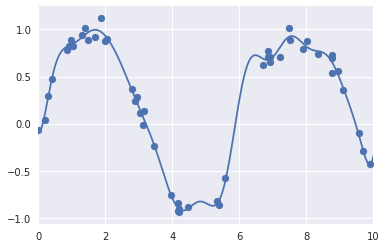

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

- This example illustrates that there is nothing magic about polynomial basis functions: if you have an intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.

### Regularization

- Linear regression with basis functions are very flexible, but they can also lead to over-fitting. If we choose too many Gaussian basis functions, we end up with results that don't look so good:

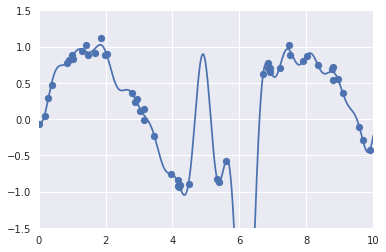

In [10]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

- This 30-D projection has too much flexibility and goes to extreme values between locations where it is constrained by data. We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

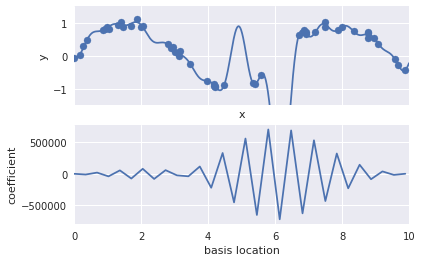

In [11]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

- The lower panel hows the amplitude of the basis function at each location. This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out.
- We know this behavior is problematic. Let's use *regularization* to limit such spikes in the model by penalizing large values of the model parameters.

### Ridge regression ($L_2$ Regularization)

- The most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*.
- It works by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 

$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$

where $\alpha$ is a parameter that controls the strength of the penalty. This type of regularization is built into Scikit-Learn with the ``Ridge`` estimator.

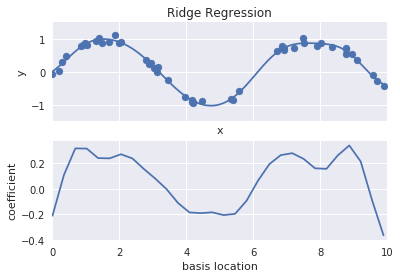

In [13]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

- The $\alpha$ parameter is a knob controlling the complexity of the resulting model. In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
- Ridge regression can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso regression ($L_1$ regularization)

- Another common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:

$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$

- Although conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets model coefficients to exactly zero.

- We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

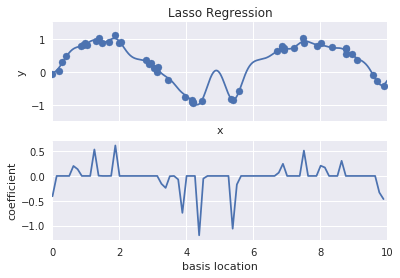

In [14]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(80), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

- Most lasso coefficients are exactly zero with the functional behavior being modeled by a small subset of the available basis functions.
- As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be found via cross-validation.

### Example: Predicting Bicycle Traffic

- Let's see if we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

- We will join the bike data with another dataset and try to correlate weather and seasonal factors—temperature, precipitation, and daylight hours—to the volume of bicycle traffic through this corridor.

- The NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.

- We will perform a linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

- Let's start by loading the two datasets, indexing by date:

In [15]:
#!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

In [16]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

- Next compute the total daily bicycle traffic, and put it in a dataframe:

In [17]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


- Account for daily variations by adding binary columns that indicate the day of the week:

In [18]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

- We expect riders to behave differently on holidays. let's add an indicator of this as well:

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

- We suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

(8, 17)

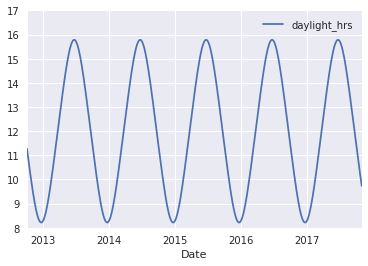

In [20]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

- We can also add average temperature and total precipitation to the data. In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [21]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

- Finally, add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:

In [22]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

- How's the data look?

In [23]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


- Now we can choose which columns to use, and fit a linear regression model to our data.
- Use ``fit_intercept = False`` because the daily flags essentially operate as their own day-specific intercepts:

In [24]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

- Display total and predicted bicycle traffic:

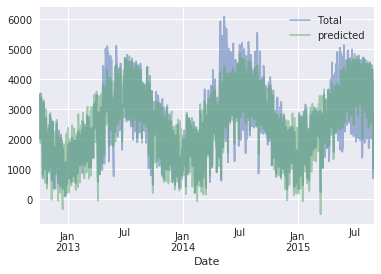

In [25]:
daily[['Total', 'predicted']].plot(alpha=0.5);

- We are apparently missing some key features, especially during the summer time.
- Review the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [26]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

- These numbers are difficult to interpret without some measure of their uncertainty. Find these uncertainties using bootstrap resamplings of the data:

In [27]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

- With these errors estimated, let's again look at the results:

In [28]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0


- There is a relatively stable trend in the weekly baseline: many more riders on weekdays than on weekends and holidays.
- For each additional hour of daylight, 129 ± 9 more people choose to ride.
- A temperature increase of one degree Celsius encourages 65 ± 4 people to grab their bicycle.
- A dry day means an average of 548 ± 33 more riders.
- Each inch of precipitation means 665 ± 62 more people leave their bike at home.
- Cumulatively we see a modest increase of 27 ± 18 new daily riders each year.

- Our model is almost certainly missing relevant information. For example, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model.
- We also have discarded some finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and you now have the tools to begin exploring them.